# MLP
Mean RCI over 14 cell lines.

This notebook uses
lncRNA, canonical, no middle-exclusion, GMM, learning module.

Load and test the model.

In [8]:
SEED = 43
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-04-29 15:44:38.904582


In [9]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = None # 'MLP'
SAVE_DESCRIM_FILENAME = None # 'GMM'
LOAD_MODEL_FILENAME = 'MLP.2.2.model'
LOAD_DESCRIM_FILENAME = 'GMM.2.2.pickle'

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [10]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = -1  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -2   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         = 0    #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [11]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = 'test.canon_lncRNA_transcripts.csv'

In [12]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [13]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-04-29 15:44:39.950148
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 4372
Num RCI: 4372
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4372 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1093
Num RCI: 1093
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 1093 sequences.

Training # 1 1
2023-04-29 15:44:50.391282
Loaded model 1 from /content/drive/My Drive/data/Localization/Models/MLP.2.2.model
Loaded model 2 from /content/drive/My Drive/data/Localization/Models/GMM.2.2.pickle

Testing # 1 1
2023-04-29 15:44:50.912810
PREDICT
Test 1:0 670:423 61.30%
Predict 1:0 694:399 63.49%
Test sizes (1093, 1025) (1093,)
Distrib of s

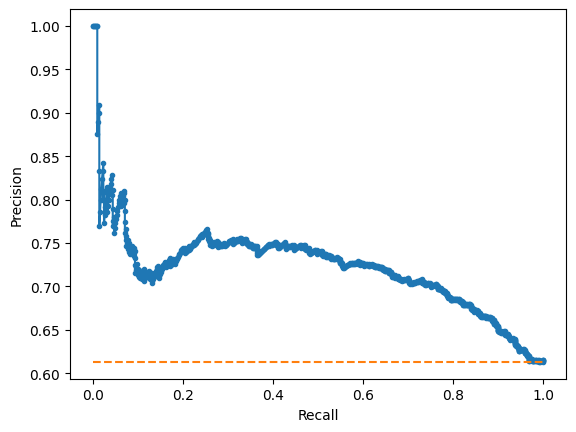

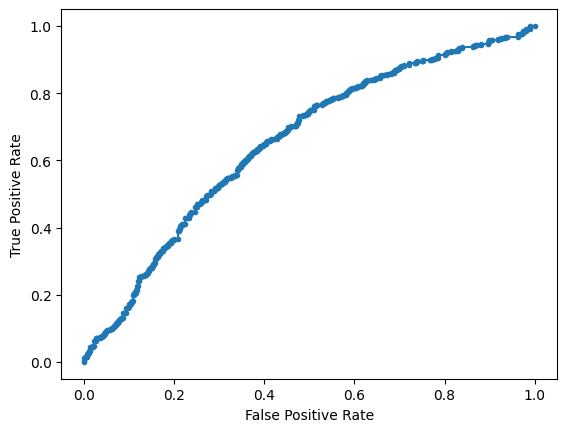

Accuracy: 64.87% Precision: 70.61% Recall: 73.13%
F1: 71.85% MCC: 0.2520
AUPRC: 72.19% AUROC: 65.33%
 accuracy [64.86733760292772]
 precision [70.60518731988472]
 recall [73.13432835820896]
 F1 [71.8475073313783]
 MCC [0.2519819391636966]
 AUPRC [72.1938188136656]
 AUROC [65.32691154158287]
2023-04-29 15:44:51.630523


In [14]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [15]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 64.87% std nan
 precision mean 70.61% std nan
 recall mean 73.13% std nan
 F1 mean 71.85% std nan
 MCC mean 0.2520 std nan
 AUPRC mean 72.19% std nan
 AUROC mean 65.33% std nan
 accuracy [[64.86733760292772]]
 precision [[70.60518731988472]]
 recall [[73.13432835820896]]
 F1 [[71.8475073313783]]
 MCC [[0.2519819391636966]]
 AUPRC [[72.1938188136656]]
 AUROC [[65.32691154158287]]


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
